In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
import cProfile
import pstats
from copy import copy
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from tukey_outliers_helper import TukeyOutliersHelper #outlier detection and removal based on IQR
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
df=pd.read_csv('D:/DS STUFF/Datasets/winequality-red.csv')

In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [10]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [11]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


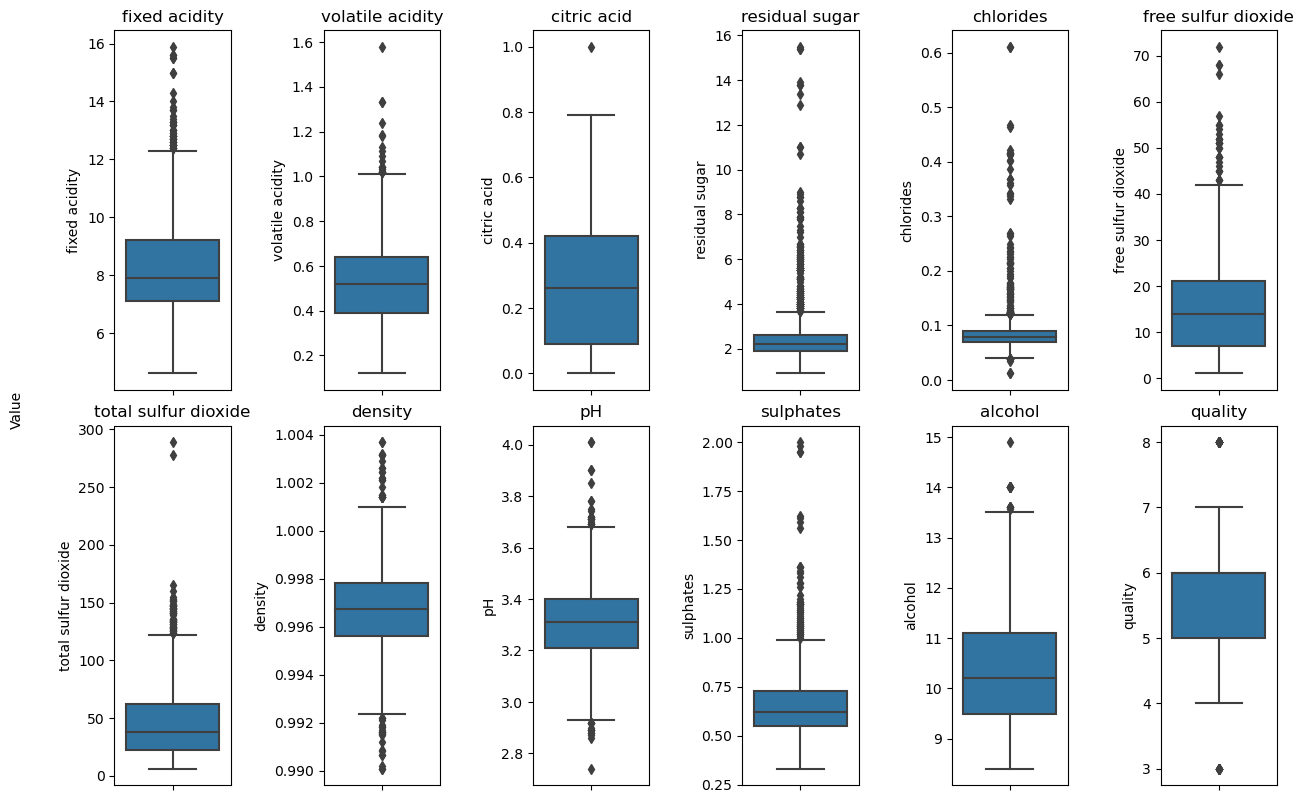

In [12]:
fig, axs = plt.subplots(2,6, figsize=(15,10), dpi=100)
fig.subplots_adjust(wspace=0.8, hspace=0.1)
axs=axs.flatten()
for i,col in enumerate(df.columns):
    sns.boxplot(y=col, data=df, ax=axs[i])
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

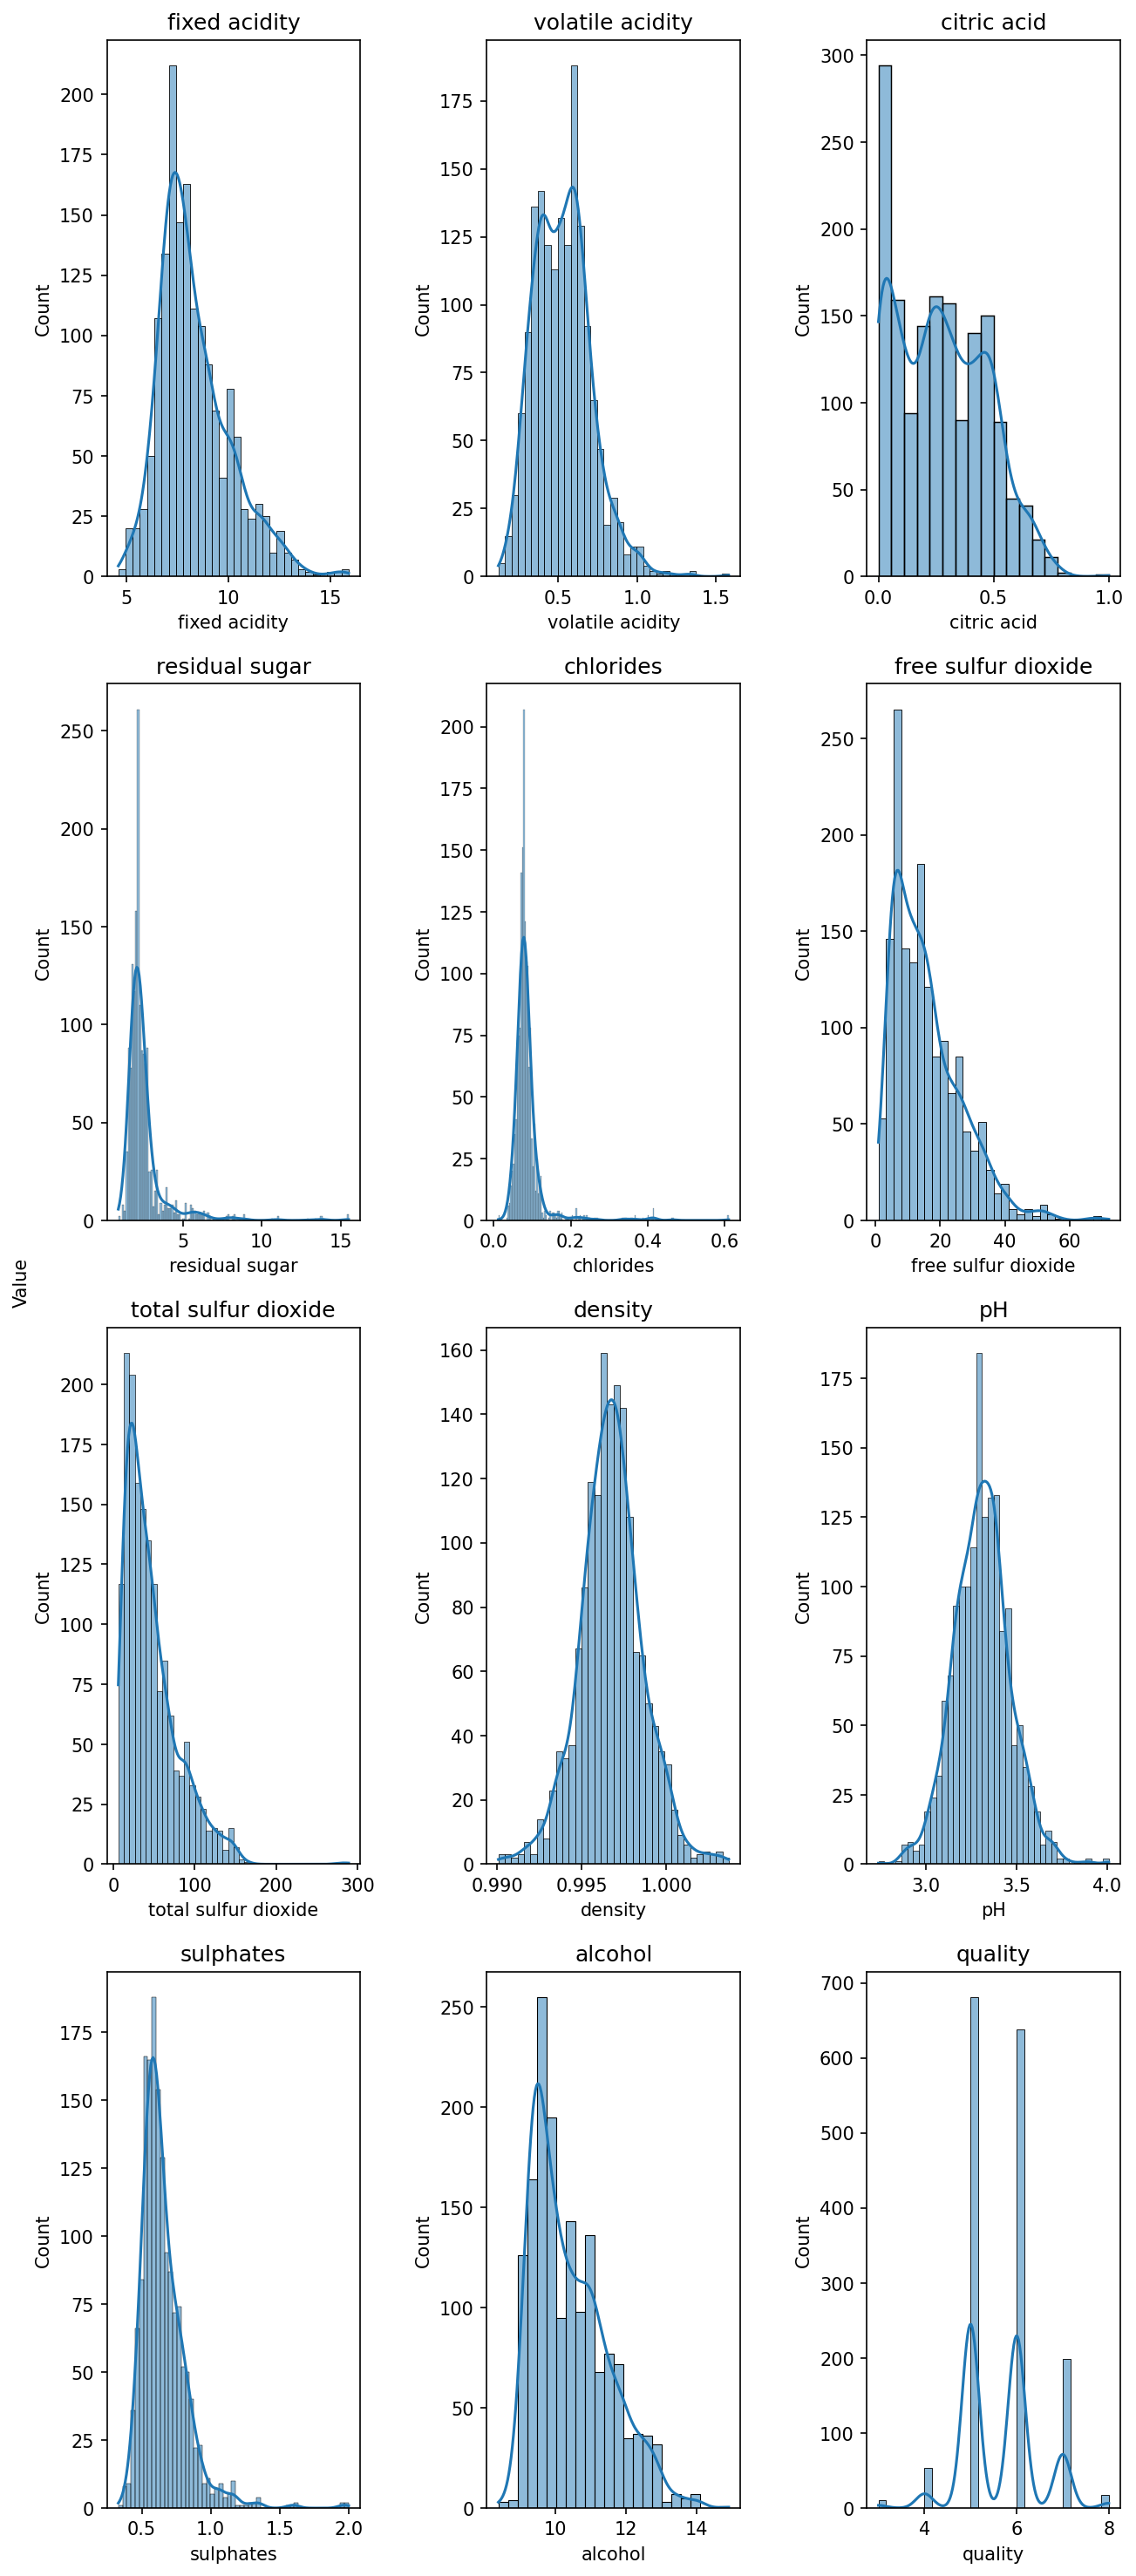

In [13]:
fig, axs = plt.subplots(4,3, figsize=(10,25), dpi=150)
fig.subplots_adjust(wspace=0.5, hspace=0.2)
axs=axs.flatten()
for i,col in enumerate(df.columns):
    sns.histplot(x=col, data=df, ax=axs[i],kde=True)
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

In [14]:
X_o=df.iloc[:,:-1]
y_o=df.iloc[:,-1]
print(f'Shape of X having predictors: {X_o.shape}, Shape of y having target: {y_o.shape}')

Shape of X having predictors: (1599, 11), Shape of y having target: (1599,)


As evident from distributions of predictors all exept quality and pH have signigicant skewness towards right so we transform these features by using log transformation to support are ML model.

In [15]:
X = X_o.copy()

In [16]:
predictors_to_transform = X.iloc[:,[0,1,2,3,4,5,6,9,10]]

In [17]:
for predictors in predictors_to_transform:
    if predictors == 'citric acid': #In the case of predictor 'Citric acid' we have 0 in our values so we use log(x+1) transformation.
        X[predictors] += 1
    X[predictors] = np.log(X[predictors])

In [18]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2.001480,-0.356675,0.000000,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710
1,2.054124,-0.127833,0.000000,0.955511,-2.322788,3.218876,4.204693,0.9968,3.20,-0.385662,2.282382
2,2.054124,-0.274437,0.039221,0.832909,-2.385967,2.708050,3.988984,0.9970,3.26,-0.430783,2.282382
3,2.415914,-1.272966,0.444686,0.641854,-2.590267,2.833213,4.094345,0.9980,3.16,-0.544727,2.282382
4,2.001480,-0.356675,0.000000,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710


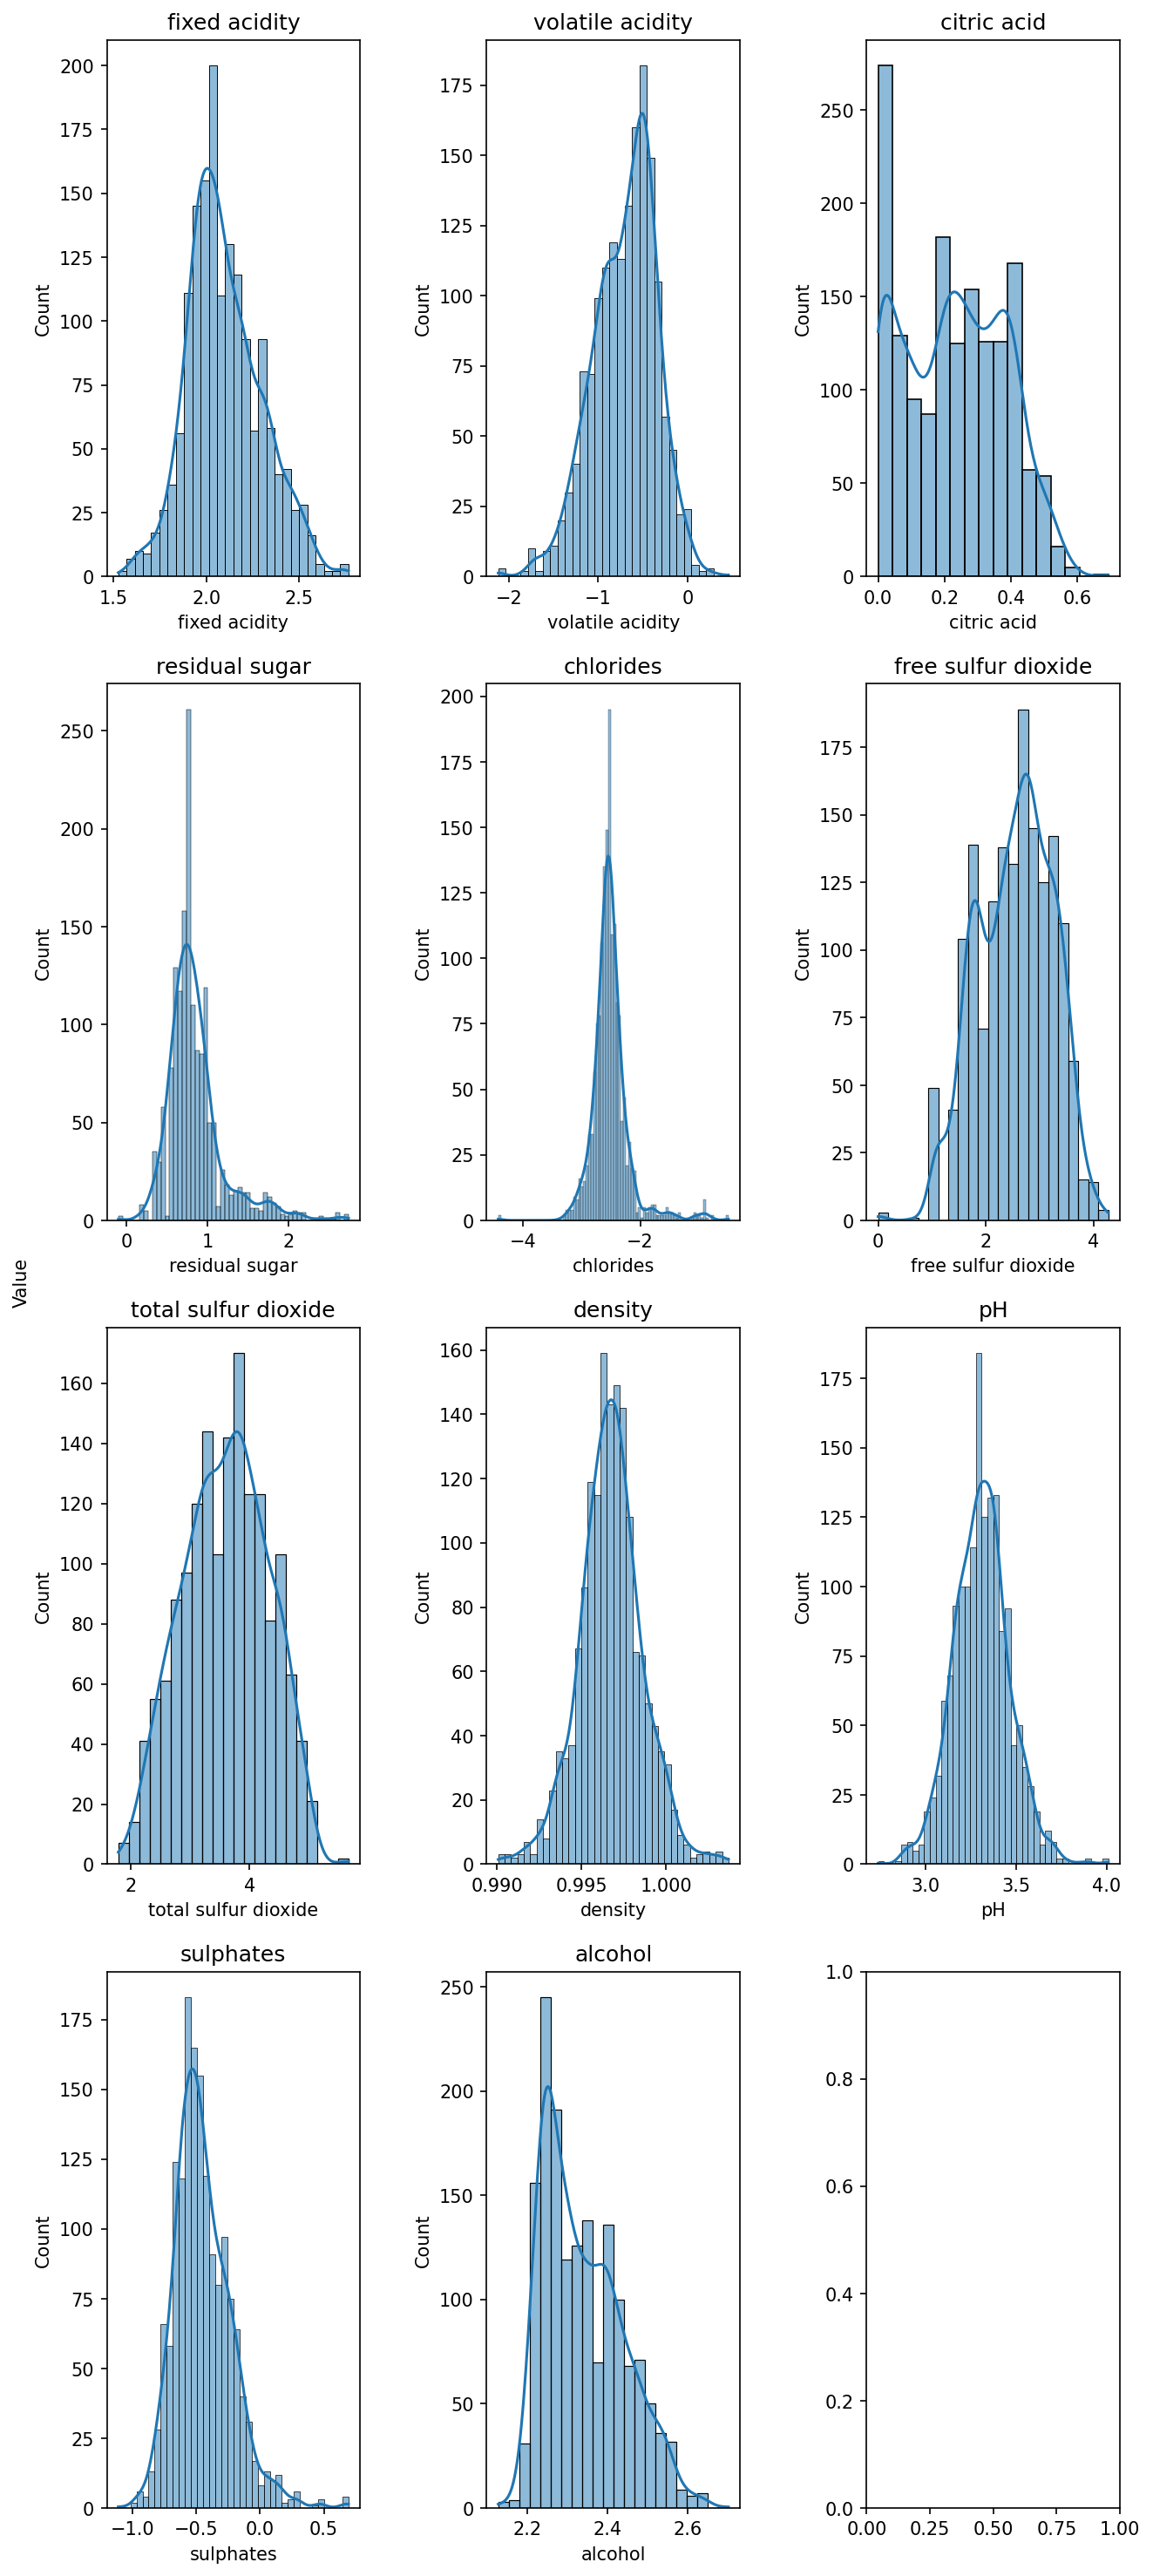

In [19]:
fig, axs = plt.subplots(4,3, figsize=(10,25), dpi=150)
fig.subplots_adjust(wspace=0.5, hspace=0.2)
axs=axs.flatten()
for i,col in enumerate(X.columns):
    sns.histplot(x=col, data=X, ax=axs[i],kde=True)
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

As evident from above distributions that the majority features have been normalized.

In [20]:
bounds = TukeyOutliersHelper().getBoundsFromDataFrame(X, kk=2.5, outlier_columns=X.columns)
bounds

fixed acidity              (1.312323034027958, 2.8669752340743067)
volatile acidity         (-2.1799121329335085, 0.7920164904466442)
citric acid              (-0.5750202421892399, 1.0118548100434617)
residual sugar          (-0.14229001096520943, 1.7396553421650405)
chlorides                 (-3.287546107635042, -1.779659537949608)
free sulfur dioxide       (-0.8006205726149613, 5.791053159393698)
total sulfur dioxide        (0.5008126241413771, 6.71736421426203)
density                            (0.9900125000000001, 1.0034225)
pH                                     (2.7350000000000003, 3.875)
sulphates                 (-1.305652640545421, 0.3931048949501002)
alcohol                   (1.8621585243270125, 2.7960783825977713)
dtype: object

In [21]:
fatal_inds_set = TukeyOutliersHelper.getOutlierDataPoints(X, bounds)

In [22]:
keep_inds = list(set(range(len(X))).difference(fatal_inds_set))
assert len(keep_inds) + len(fatal_inds_set) == len(X)

In [23]:
X_cleaned = X.iloc[keep_inds]
X_cleaned.shape

(1479, 11)

In [24]:
y_cleaned = y_o.iloc[keep_inds]
y_cleaned.shape

(1479,)

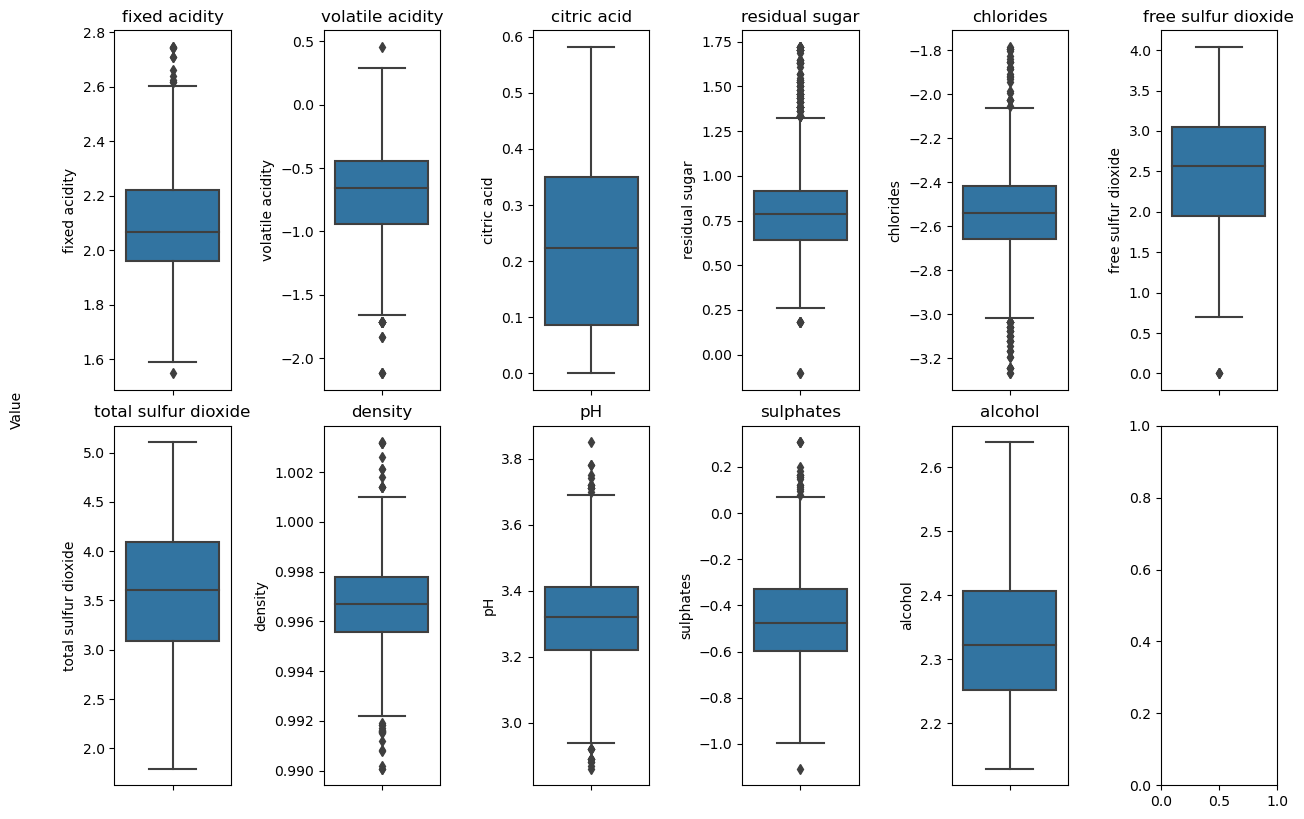

In [25]:
fig, axs = plt.subplots(2,6, figsize=(15,10), dpi=100)
fig.subplots_adjust(wspace=0.8, hspace=0.1)
axs=axs.flatten()
for i,col in enumerate(X_cleaned.columns):
    sns.boxplot(y=col, data=X_cleaned, ax=axs[i])
    axs[i].set_title(col)
    
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

In [26]:
new_df=pd.concat([X_cleaned, y_cleaned], axis=1)
new_df #complete dataset with cleaned and transformed values

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,2.001480,-0.356675,0.000000,0.641854,-2.577022,2.397895,3.526361,0.99780,3.51,-0.579818,2.240710,5
1,2.054124,-0.127833,0.000000,0.955511,-2.322788,3.218876,4.204693,0.99680,3.20,-0.385662,2.282382,5
2,2.054124,-0.274437,0.039221,0.832909,-2.385967,2.708050,3.988984,0.99700,3.26,-0.430783,2.282382,5
3,2.415914,-1.272966,0.444686,0.641854,-2.590267,2.833213,4.094345,0.99800,3.16,-0.544727,2.282382,6
4,2.001480,-0.356675,0.000000,0.641854,-2.577022,2.397895,3.526361,0.99780,3.51,-0.579818,2.240710,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,1.824549,-0.510826,0.076961,0.693147,-2.407946,3.465736,3.784190,0.99490,3.45,-0.544727,2.351375,5
1595,1.774952,-0.597837,0.095310,0.788457,-2.780621,3.663562,3.931826,0.99512,3.52,-0.274437,2.415914,6
1596,1.840550,-0.673345,0.122218,0.832909,-2.577022,3.367296,3.688879,0.99574,3.42,-0.287682,2.397895,6
1597,1.774952,-0.438505,0.113329,0.693147,-2.590267,3.465736,3.784190,0.99547,3.57,-0.342490,2.322388,5


<AxesSubplot:>

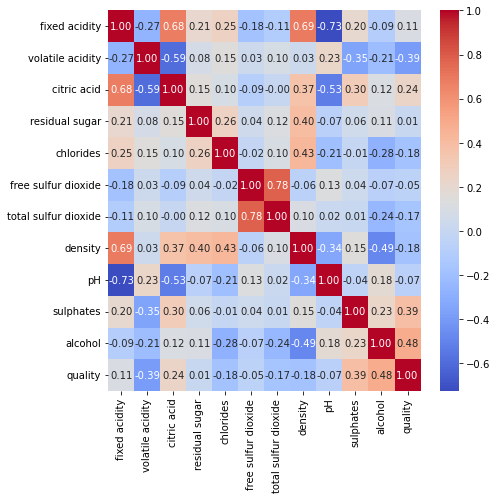

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(data=new_df.corr(), annot=True, fmt='.2f',cmap='coolwarm', ax=ax)
#Correlation matrix

In [28]:
corr_new_df = pd.DataFrame(columns=['absolute correlation coefficient', 'p_value'], index=new_df.columns)
for col1 in new_df.columns:
    for col2 in new_df.columns:
        # Calculate Pearson correlation coefficient and p-value
        corr, p = pearsonr(new_df[col1], new_df[col2])
        # Store absolute value of correlation coefficient and p-value in dataframe
        corr_new_df.loc[col1, 'absolute correlation coefficient'] = abs(corr)
        corr_new_df.loc[col1, 'p_value'] = p
        
corr_new_df = corr_new_df.astype(float)
corr_new_df = corr_new_df.sort_values(by='absolute correlation coefficient', ascending=False)


In [29]:
corr_new_df

,absolute correlation coefficient,p_value
quality,1.000000,0.000000e+00
alcohol,0.484643,5.826431e-88
sulphates,0.392419,1.223569e-55
volatile acidity,0.390643,4.134148e-55
citric acid,0.235577,4.245945e-20
chlorides,0.184983,7.501754e-13
density,0.184764,7.988600e-13
total sulfur dioxide,0.171488,3.164532e-11
fixed acidity,0.107971,3.168981e-05
pH,0.067825,9.075283e-03


Strong Correlation: Alcohal, sulphates, volatile acidity, citric acid

Note that pearson correlation is a first indication of whether a factor that plays a weaker or stronger role to predicting the quality of the wine. We should build our classifier to quantify it better



In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned,test_size=0.1, random_state=42)

In [31]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(type(X_train),type(y_train))

X_train shape: (1331, 11)
X_test shape: (148, 11)
y_train shape: (1331,)
y_test shape: (148,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [32]:
m_X_train = X_train.values
m_y_train = y_train.values
m_X_test = X_test.values
m_y_test = y_test.values

In [33]:
print('Vectorized X_train:', m_X_train.shape )
print('Vectorized X_test:', m_X_test.shape )
print('Vectorized y_train:', m_y_train.shape )
print('Vectorized y_test:', m_y_test.shape )
print(type(m_X_train),type(m_y_train))

Vectorized X_train: (1331, 11)
Vectorized X_test: (148, 11)
Vectorized y_train: (1331,)
Vectorized y_test: (148,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [34]:
#Normalizing features before Gradeint descent is applied
scaler = StandardScaler()
m_X_train_norm=scaler.fit_transform(m_X_train)

In [35]:
#initializing weights and bias with small random numbers drawn from normal distribution having mean=0 and std=1
w_init=np.random.randn(11)*0.01 #11 features, 1 output
b_init=np.random.randn(1)*0.01 
print(type(w_init),type(b_init))
print(w_init.shape,b_init.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(11,) (1,)


In [87]:
#Computing the cost for gradient descent
def compute_cost(X,y,w,b):
    m=X.shape[0]
    f_wb_i= np.dot(X,w)+b
    cost=np.sum(np.square(np.subtract(f_wb_i,y)))/(2*m)
    return cost

def compute_gradient(X,y,w,b):
    m,n = X.shape
    err = np.dot(X, w) + b - y
    dj_dw = np.dot(X.T, err) / m
    dj_db = np.sum(err) / m
    return dj_db, dj_dw

def gradient_descent(X,y,w_in,b_in,cost_func,gradient_func,alpha,num_iters):
    j_hist = []
    w=copy(w_in)
    b=b_in
    
    for i in range(num_iters):
        dj_db,dj_dw=gradient_func(X,y,w,b)
        
        w = w - alpha* dj_dw
        b = b - alpha * dj_db
        
        if i < 10000:
            j_hist.append(cost_func(X,y,w,b))
            
        if i%math.ceil(num_iters/20)==0:
             print(f"Iteration {i:4d}: Cost {j_hist[-1]:8.2f}   ")
    return w, b, j_hist

In [88]:
#Normalizing features before Gradeint descent is applied
scaler = StandardScaler()
m_X_train_norm=scaler.fit_transform(m_X_train)

In [89]:
# initial_w = np.zeros_like(w_init)
# initial_b = 0.

iterations = 50
alpha = 0.05

w_final, b_final, j_hist = gradient_descent(m_X_train_norm, m_y_train, w_init, b_init, compute_cost, compute_gradient, alpha, iterations)
print(f"b,w found by gradient descent: {b_final},{w_final}")


m,_ = m_X_train_norm.shape
for i in range(m):
    prediction = np.dot(m_X_train_norm[i], w_final) + b_final 
    print(f"prediction: {prediction}, target value: {m_y_train[i]}")

Iteration    0: Cost    14.59   
Iteration    3: Cost    10.76   
Iteration    6: Cost     7.95   
Iteration    9: Cost     5.89   
Iteration   12: Cost     4.38   
Iteration   15: Cost     3.27   
Iteration   18: Cost     2.46   
Iteration   21: Cost     1.86   
Iteration   24: Cost     1.42   
Iteration   27: Cost     1.09   
Iteration   30: Cost     0.85   
Iteration   33: Cost     0.68   
Iteration   36: Cost     0.55   
Iteration   39: Cost     0.46   
Iteration   42: Cost     0.39   
Iteration   45: Cost     0.34   
Iteration   48: Cost     0.30   
b,w found by gradient descent: [5.20105075],[ 0.05740057 -0.14639582  0.01617324  0.02061571 -0.05173232  0.02627286
 -0.07384756 -0.08566665 -0.02835574  0.1838527   0.22552772]
prediction: [5.66898244], target value: 6
prediction: [6.03954418], target value: 7
prediction: [4.81681308], target value: 5
prediction: [5.06496848], target value: 5
prediction: [5.12921944], target value: 6
prediction: [4.63913982], target value: 5
predicti

prediction: [5.50943853], target value: 6
prediction: [5.87101149], target value: 6
prediction: [5.25561363], target value: 6
prediction: [4.68012504], target value: 5
prediction: [5.65415718], target value: 6
prediction: [5.25513323], target value: 6
prediction: [4.89122411], target value: 5
prediction: [5.05355883], target value: 6
prediction: [5.91496551], target value: 6
prediction: [5.38262587], target value: 5
prediction: [4.72633756], target value: 6
prediction: [4.63845748], target value: 5
prediction: [5.3327798], target value: 6
prediction: [5.0402428], target value: 6
prediction: [5.07814101], target value: 6
prediction: [6.02464228], target value: 7
prediction: [5.86060967], target value: 7
prediction: [6.05330041], target value: 6
prediction: [5.11594797], target value: 5
prediction: [5.42400007], target value: 4
prediction: [4.94757514], target value: 6
prediction: [4.74887626], target value: 5
prediction: [5.06252608], target value: 6
prediction: [5.13048771], target val

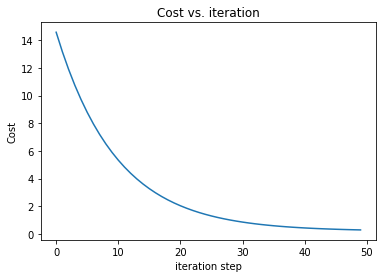

In [90]:
plt.plot(j_hist)
plt.title("Cost vs. iteration")
plt.ylabel('Cost')              
plt.xlabel('iteration step')   
plt.show()
#We can see that our gradient descent worked as the cost is reducing with every iteration.

In [91]:
predicted_train = np.dot(m_X_train_norm, w_final) + b_final  # make predictions on the training set
residual_train = m_y_train - predicted_train
rmse_train = np.sqrt(mean_squared_error(m_y_train, predicted_train))  # compute RMSE
print("RMSE on training set:", rmse_train)

RMSE on training set: 0.7592410425978214


In [92]:
#Normalizing features before Gradeint descent is applied
scaler = StandardScaler()
m_X_test_norm=scaler.fit_transform(m_X_test)

In [93]:
predicted_test = np.dot(m_X_test_norm, w_final) + b_final  # make predictions on the training set
residual_test = m_y_test - np.dot(m_X_test_norm, w_final) + b_final
rmse_test = np.sqrt(mean_squared_error(m_y_test, predicted_test))  # compute RMSE
print("RMSE on training set:", rmse_test)


RMSE on training set: 0.8437867038003314


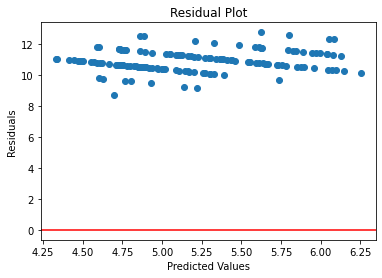

In [100]:
plt.scatter(predicted_test, residual_test)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

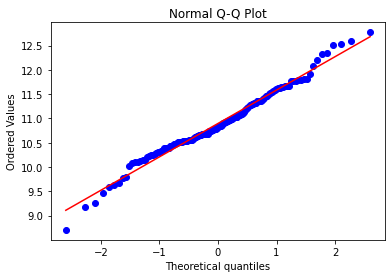

In [99]:
stats.probplot(residual_test, dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

In [101]:
# Convert numpy arrays to pandas dataframes
df_X_test = pd.DataFrame(m_X_test_norm, columns=['Fixed Acidity', 'Volatile Acidity', 'citric acid', 'residual sugar', 'chlorides','free sulfur dioxide', 'total sulfur dioxide','density','pH', 'sulphates', 'alcohal'])
df_y_test = pd.DataFrame(m_y_test, columns=["Quality"])
df_predicted_test = pd.DataFrame(predicted_test, columns=["Predicted Quality"])

# Concatenate the dataframes horizontally
df_train = pd.concat([df_X_test, df_y_test, df_predicted_test], axis=1)

# Fit an OLS model and get ANOVA table
model = ols('Quality ~ Q("Fixed Acidity") + Q("Volatile Acidity") + Q("citric acid") + Q("residual sugar") + Q("chlorides") + Q("free sulfur dioxide") + Q("total sulfur dioxide") + Q("density") + Q("pH") + Q("sulphates") + Q("alcohal") ', data=df_train).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)

                              sum_sq     df          F        PR(>F)
Q("Fixed Acidity")          2.139694    1.0   4.906930  2.841280e-02
Q("Volatile Acidity")       1.732305    1.0   3.972672  4.824531e-02
Q("citric acid")            0.042278    1.0   0.096955  7.559919e-01
Q("residual sugar")         0.395263    1.0   0.906450  3.427470e-01
Q("chlorides")              0.006796    1.0   0.015586  9.008325e-01
Q("free sulfur dioxide")    0.015046    1.0   0.034506  8.529116e-01
Q("total sulfur dioxide")   0.035098    1.0   0.080489  7.770678e-01
Q("density")                1.105890    1.0   2.536122  1.135894e-01
Q("pH")                     5.749070    1.0  13.184264  3.987813e-04
Q("sulphates")              5.431227    1.0  12.455359  5.691732e-04
Q("alcohal")               11.484652    1.0  26.337594  9.693237e-07
Residual                   59.303541  136.0        NaN           NaN


Performing ridge regularization.

In [111]:
ridge = Ridge(alpha=1.0)
ridge.fit(m_X_train_norm, m_y_train)
y_pred = ridge.predict(m_X_test_norm)
residual= m_y_test - y_pred
mse = mean_squared_error(m_y_test, y_pred)
rmse_test = np.sqrt(mse)  # compute RMSE
print("RMSE on test set after L2 regularization:", rmse_train)

RMSE on test set after L2 regularization: 0.7592410425978214


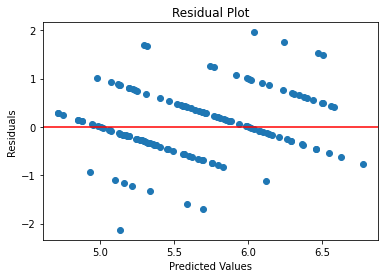

In [112]:
plt.scatter(y_pred, residual)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

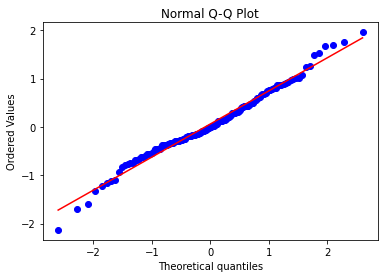

In [113]:
stats.probplot(residual, dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

In [114]:
# Compute the total sum of squares (TSS)
tss = np.sum((m_y_test - np.mean(m_y_test))**2)

# Compute the residual sum of squares (RSS)
rss = np.sum(residual**2)

# Compute the explained sum of squares (ESS)
ess = tss - rss

# Compute the degrees of freedom
n = len(m_y_test)
p = m_X_test_norm.shape[1]
df_tss = n - 1
df_rss = n - p - 1
df_ess = p

# Compute the mean square
ms_rss = rss / df_rss
ms_ess = ess / df_ess

# Compute the F-statistic
f_stat = ms_ess / ms_rss

# Compute R^2 Coefficient of determinant
R_2=rss/tss


print(f"tss: {tss}, rss: {rss}, R_2: {R_2},f_stat: {f_stat}")

tss: 117.31756756756756, rss: 69.23201510860235, R_2: 0.5901248768112163,f_stat: 8.58724513528331


The coefficient of determination for this model is 59% that is this does not account well for the variation in this model. 

In the second iteration we will drop all the features having P-value < 0.05 and re run the entire process and check wheter the coefficient of determination justifies it to be a good linear fit model.
